## MathGR5430 Final Project: Deep Q-Learning Trading Bot that can buy, sell and hold stocks based on his inferences.


Konstantin Kuchenmeister (kk3506@columbia.edu)   



#### Sources:

https://github.com/openai/gym

https://towardsdatascience.com/reinforcement-learning-w-keras-openai-dqns-1eed3a5338c

https://www.youtube.com/watch?v=x0ycf3SZic4


In [ ]:
import numpy as np
from numpy import random
import random
import pandas as pd
import tensorflow as tf
from datetime import datetime
import itertools
import argparse
import re
import os
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import MinMaxScaler
from collections import deque 
      
from keras.models import Sequential
from keras.layers import Dense

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [ ]:
def getData():
  '''
  getData retrieves the closing values of the security that is used for training
  and prediciton
  ''' 
  stock = pd.read_csv('BP.csv') # loading the dataset
  stock = stock.dropna() # dropping all possible NA values

  # EDA
  print(stock.head)
  print(stock.describe())  
  return stock.iloc[:, 5].values.reshape(-1,1) # return all adjusted closing prices

<bound method NDFrame.head of              Date       Open       High        Low      Close  Adj Close  \
0      1962-01-02   0.000000   0.716684   0.706999   0.706999   0.053105   
1      1962-01-03   0.000000   0.716684   0.710227   0.716684   0.053832   
2      1962-01-04   0.000000   0.718298   0.703771   0.703771   0.052863   
3      1962-01-05   0.000000   0.703771   0.677944   0.684401   0.051408   
4      1962-01-08   0.000000   0.703771   0.694086   0.697314   0.052378   
...           ...        ...        ...        ...        ...        ...   
15197  2022-05-16  30.620001  31.290001  30.600000  31.020000  31.020000   
15198  2022-05-17  31.559999  31.690001  31.270000  31.480000  31.480000   
15199  2022-05-18  31.879999  32.060001  30.940001  31.110001  31.110001   
15200  2022-05-19  30.549999  31.389999  30.549999  31.030001  31.030001   
15201  2022-05-20  31.370001  31.799999  30.750000  31.280001  31.280001   

         Volume  
0         77440  
1         85184  
2  

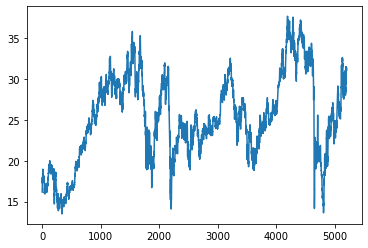

In [ ]:
bp = getData()
print("Shape:", bp.shape)

# We drop the first 10000 values since it is too easy to make money and does not
# reflect current volatilities
plt.plot(bp[10_000:])

# 1. Create the Environment 
 
The environment represents all the "world" where the agent resides and stores all the data based on which the agent makes a decision.

In [ ]:
class TradingEnvironment:

  def __init__(self, data, initial_money):
    self.stock_prices = data # the time series data of the security

    self.initial_money = initial_money # the initial amount of money the agent gets
    self.shares_owned = None # the number of shares owned
    self.cash = None # the amount of cash on top shares owned
    self.stock_price = None # the current stock price at the current step

    self.n_steps = data.shape[0] # the number of observations in the data set
    self.curr_step = None # the current step

    self.actions = [0,1,2] # Define 3 actions: Sell = 0, Hold = 1, Buy = 2

    self.reset()

  def get_state(self):
    '''
    get_state returns the current representaiton of the environment to the agent.
    The state is stored in the form of a numpy array with:
        1. number of shares in the portfolio at state s at time t
        2. current stock price at which the shares are traded in state s at time t
        3. amount of cash the agent has in the portfolio
    '''
    state = np.zeros(3) # intialize the state
    state[0] = float(self.shares_owned) # the number of shares
    state[1] = float(self.stock_price) # the current stock price
    state[2] = float(self.cash) # the amount of cash
    return state


  def reset(self):
    '''
    reset resets the environment to an standardized initial starting state.
    This will be done in the beginning of each episode durin the training phase.
    The agent will be placed at the beginning of the time series, owning no
    shares but having the amount of intial cash given.
    This function will then give the agent the state of this first standard
    environment.
    '''
    self.curr_step = 0 # first point in the time series
    self.shares_owned = 0 # owning no shares
    self.stock_price = self.stock_prices[self.curr_step] # stock price at time t = 0
    self.cash = self.initial_money # agent will have the initial investment at t = 0
    return self.get_state() # return the first state to the agent
    

  def trade(self, action, scaling=False):
    '''
    At every timestep during each episode the agent will perform an action.
    He will trade, implying he will buy sell or hold.
    If he decides to buy, he will buy shares until we run out of money.
    If he decides to sell, he will sell all our shares giving us the money back.
    If he decides to hold, he will earn the risk free interest rate.
    '''

    # sell all shares
    if action == 0:
      # we will get the current value of the shares back to our cash account

      # punish the agent if he tries to sell when he doesn't have stocks,
      # otherwise he will give too much weight to selling
      if self.shares_owned > 0:
        self.cash = self.cash + self.stock_price * self.shares_owned
        # selling all shares
        self.shares_owned = 0


    # buy shares until we run out of money
    if action == 2:
      liquid = True

      # as long as we have cash, buy a share
      while liquid:
        if self.cash >= self.stock_price:
          self.shares_owned = self.shares_owned + 1 # buy a share
          self.cash = self.cash - self.stock_price # deduct the money
          #print("I bought a share for:", self.stock_price, "we own", self.shares_owned, "shares.")
        else:
          liquid = False

      if action == 1:
         # for each trading day the agent chooses to not do anything, he earns the risk free interest rate
        self.cash = self.cash * 1+(0.01/252)

  def _get_balance(self):
    ''' 
    _get_balance will return the current balance which is the number of shares 
    we own times the stock price plus the cash we have
    '''
    return self.shares_owned * self.stock_price + self.cash

  
  def make_step(self, action, scaling=False):
    '''
    At every time step of the time series, make a step. The agent retrieves a new
    representation of the state, makes a step, receives the reward with the new state.
    '''
    balance = self._get_balance() # the balance before the step

    self.curr_step = self.curr_step + 1 # making a step

    self.stock_price = self.stock_prices[self.curr_step] # updating the stock price

    self.trade(action, scaling) # performing the trade

    newbalance = self._get_balance() # storing the new balance

    reward = newbalance - balance # the reward will be the profit of the trade

    # an episode can end based on two conditions:
    # either we are at the last step
    # or we ran out of money, in this case if the trades are so bad we lost 95%
    done = False # indicates whether the current episode is done
    if self.curr_step == self.n_steps-1:
      done = True
    elif newbalance <= self.initial_money * .05:
      done = True
    else:
      done = False
    #done = self.curr_step == self.n_steps-1 # if we are at the last 
    if not scaling:
      print(done)
      # verbosity
      print("Step:", self.curr_step)
      print("Old Balance", balance, " New Balance:", newbalance, "Reward:", reward, "Action", action)

    # returning the info to the agent
    return self.get_state(), reward, done, newbalance

# 2. Create the Agent 

(with deep neural network)

In [ ]:
# this deep neural network predicts the q-values (aka the expected value of future rewards after performing that action in the current state)
def model(obs_count, neurons=32, layers=2):
  '''
  model() creates a deep learning model that replaces the Q-Table. 
  Out of the box, it is configured with 32 neurons, 1 input, 2 hidden and 1 output 
  layer. We regressionally output 3 values, for the 3 actions we defined.
  '''
  model = Sequential()
  model.add(Dense(neurons, input_shape=(obs_count,), activation='relu'))
  for _ in range(layers):
    model.add(Dense(neurons, activation='relu'))
  model.add(Dense(3, activation='linear')) # 3, since we have 3 actions
  history = model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mean_squared_error'])

  return model

In [ ]:
class TradingAgent:

  def __init__(self, state_size):
    '''
    creates an Agent object.
    '''
    self.memory = deque(maxlen=2000) # the replay memory for training
    self.state_size = state_size # the size of the states


    # for the q-formula:
    self.gamma = 0.95 # discount rate, we want future rewards to be worth less 
    self.epsilon = 1.0 # exploration factor, see act function
    self.epsilon_min = 0.01
    self.epsilon_decay = 0.995 # 5 percent decay

    self.model = model(state_size) # the policy network
    self.target_model = model(state_size) # the target network

  def update_replay_buffer(self, state, action, reward, next_state, done):
    '''
    update_replay_buffer() stores the current S,A,R,S,d tuple into the replay buffer,
    so that we can use for training later.
    '''
    #if len(state[1]) > 0:
    self.memory.append((state, action, reward, next_state, done)) # append to buffer
    #print("memory", self.memory)


  def act(self, state):
    '''
    the act() method chooses an action based on the state it receives from the 
    environment. It integrates the exploration vs exploitation using a uniformly
    sampled random value that is compared to a decying exploration rate
    '''
    # we dont always want the model to do the same things it remembers, so choose a random action from time 
    # to time (especially during beginning, since we let epsilon decay) so that we can learn new things
    # and dont just perform things we know provide good reward 
    if np.random.rand() <= self.epsilon:
      r_action = random.randrange(3)
      return r_action

    # calculate Q(s, a)
    state = state.reshape(1,3)
    #test = np.zeros((3,3)) # my model will take any matrix that is x, 3
    act_values = self.model.predict(state)
    
    action = np.argmax(act_values[0])
    #print("Im choosing action", action)
    return action  # returns action


  def replay(self, batch_size=32):
    '''
    replay() represents the "train" function of the project. It uses minibatch training.
    We uniformly sample (S,A,R,S) tuples from the replay buffer and perform training on
    these batches during the training phase. Does not get called during testing.
    Predicts the values of the q-table (deep q-learning) and then trains based on the results.
    '''
    if len(self.memory) < batch_size:
      return

    # Samples us batch_size times (state, action, reward, next_state, done)
    # because we want to actively learn (train) from what we have learned in the past
    minibatch = random.sample(self.memory, batch_size)


    states = np.array([tup[0] for tup in minibatch]) # Retrieves all states from the memory
    actions = np.array([tup[1] for tup in minibatch])
    rewards = np.array([tup[2] for tup in minibatch])
    next_states = np.array([tup[3] for tup in minibatch])
    done = np.array([tup[4] for tup in minibatch])

    # Q(s', a)
    # optimal q-values fulfill the Bellman equation
    next_states = next_states.reshape(batch_size,3)
    # calculate the target using the target network
    target = rewards + self.gamma * np.max(self.target_model.predict(next_states), axis=1)
    target[done] = rewards[done]


    # Q(s, a)
    # for each state, we attempt to the predict the q value of that state, since we do not/can not store the whole table
    #print(states.shape)
    states = states.reshape(batch_size, 3)
    target_f = self.model.predict(states)
    #target_f[range(batch_size), actions] = target

    # the labels are in this case the optimal q values from the bellman equation
    # run one training step
    self.model.fit(states, target_f, epochs=1, verbose=0)
    
    # lower the exploration rate to make the act of exploration less likely as
    # the model learns more about the environment
    if self.epsilon > self.epsilon_min:
      self.epsilon *= self.epsilon_decay
    
    
  def target_train(self):
    ''' 
    target_train() "trains" the target network, where we copy all weights from the 
    policy network to the target network so we do not have to hit a moving target
    '''
    weights = self.model.get_weights()
    target_weights = self.target_model.get_weights()
    for i in range(len(target_weights)):
      target_weights[i] = weights[i]
      self.target_model.set_weights(target_weights)

# 3. Data preparation

Includes: Scaling,...

In [ ]:
def get_scaler(env):
  '''
  get_scaler() returns scikit-learn's scaler object fitted to set of possible states 
  to scale the states during training.
  scale the state, not the data itself, otherwise we will just buy  for the scaled price...
  '''

  # Query a possible state for each timestep
  states = []
  for _ in range(env.n_steps):
    action = np.random.choice(env.actions)
    state, reward, done, balance = env.make_step(action, True) # true that we are scaling
    states.append(state)
    if done:
      break

  # fit a standardscaler to the set of states
  scaler = StandardScaler()
  scaler.fit(states)
  return scaler    

# 4. Play one episode functionality

In [ ]:
def play_episode(agent, env, train, scaler, data_length, batch_size=32):
  '''
  play_episode() runs the "game" of trading once. This includes
  buying, selling, holding the stock until we either are at the last step or run 
  out of money. If we enable "training" mode we will replay after each action and
  improve our model by calling the replay/train function, while continously adding
  (S,A,R,S) to the memory.
  '''
  state = env.reset() # reset the state
  state = scaler.transform([state]) # scale the states
  done = False # intialize done, get set to True as we are done with an episode

  balances = list()
  actions = list()
  while not done:
    action = agent.act(state) # select an action

    # make a step based on that action and return the (S,A,R,S) tuple
    next_state, reward, done, balance = env.make_step(action)
    actions.append(action) # for analyzing only 
    balances.append(balance) # for analyzing only
    next_state = scaler.transform([next_state])
    if train:
      
      # store the (S,A,R,S) to the replay memory
      agent.update_replay_buffer(state, action, reward, next_state, done)
      # perform training once
      agent.replay(batch_size)
      # update the target network
      agent.target_train()
    # advance to the next state
    state = next_state
  
  return balances, actions # return the current total balance/reward and the reward against time


# 5. Train and Main

<bound method NDFrame.head of              Date       Open       High        Low      Close  Adj Close  \
0      1962-01-02   0.000000   0.716684   0.706999   0.706999   0.053105   
1      1962-01-03   0.000000   0.716684   0.710227   0.716684   0.053832   
2      1962-01-04   0.000000   0.718298   0.703771   0.703771   0.052863   
3      1962-01-05   0.000000   0.703771   0.677944   0.684401   0.051408   
4      1962-01-08   0.000000   0.703771   0.694086   0.697314   0.052378   
...           ...        ...        ...        ...        ...        ...   
15197  2022-05-16  30.620001  31.290001  30.600000  31.020000  31.020000   
15198  2022-05-17  31.559999  31.690001  31.270000  31.480000  31.480000   
15199  2022-05-18  31.879999  32.060001  30.940001  31.110001  31.110001   
15200  2022-05-19  30.549999  31.389999  30.549999  31.030001  31.030001   
15201  2022-05-20  31.370001  31.799999  30.750000  31.280001  31.280001   

         Volume  
0         77440  
1         85184  
2  

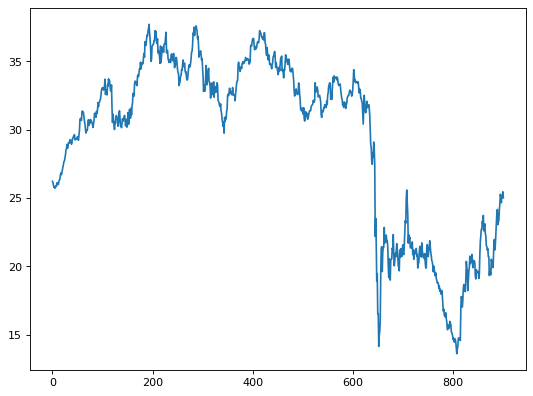

In [17]:
print("Shape:",getData().shape)
figure(figsize=(8, 6), dpi=80)
plt.plot(getData()[14000:len(getData())-300])

<bound method NDFrame.head of              Date       Open       High        Low      Close  Adj Close  \
0      1962-01-02   0.000000   0.716684   0.706999   0.706999   0.053105   
1      1962-01-03   0.000000   0.716684   0.710227   0.716684   0.053832   
2      1962-01-04   0.000000   0.718298   0.703771   0.703771   0.052863   
3      1962-01-05   0.000000   0.703771   0.677944   0.684401   0.051408   
4      1962-01-08   0.000000   0.703771   0.694086   0.697314   0.052378   
...           ...        ...        ...        ...        ...        ...   
15197  2022-05-16  30.620001  31.290001  30.600000  31.020000  31.020000   
15198  2022-05-17  31.559999  31.690001  31.270000  31.480000  31.480000   
15199  2022-05-18  31.879999  32.060001  30.940001  31.110001  31.110001   
15200  2022-05-19  30.549999  31.389999  30.549999  31.030001  31.030001   
15201  2022-05-20  31.370001  31.799999  30.750000  31.280001  31.280001   

         Volume  
0         77440  
1         85184  
2  

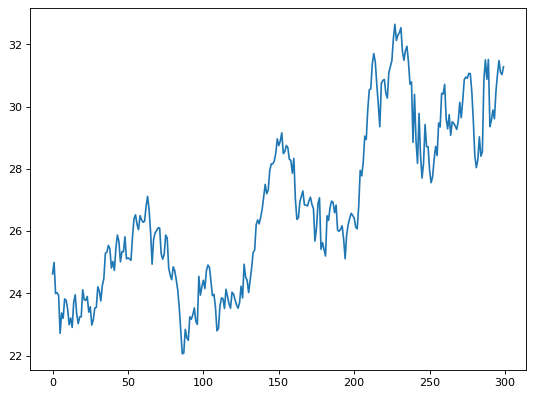

In [19]:
figure(figsize=(8, 6), dpi=80)
plt.plot(getData()[-300:])

In [10]:
#data = getData()[7000:]

train = getData()[14000:len(getData())-300]
test = getData()[-300:]


trainEnv = TradingEnvironment(train, 100) # Create the Environment

scaler = get_scaler(trainEnv) # get the scaler object for the replay function

state_dim = 1*2+1
gordongecko = TradingAgent(state_dim) # Create the Agent

EPISODES = 15 # Adjust as wished

returns_ = list()
actions_ = list()

# Perform training
for e in range(EPISODES):
  print("Episode:",e)
  balances, actions = play_episode(gordongecko, trainEnv, True, scaler, EPISODES, train.shape[0])
  returns_.append(balances)
  actions_.append(actions)

Streaming output truncated to the last 5000 lines.
Old Balance [100.]  New Balance: [100.] Reward: [0.] Action 1
False
Step: 137
Old Balance [100.]  New Balance: [100.] Reward: [0.] Action 1
False
Step: 138
Old Balance [100.]  New Balance: [100.] Reward: [0.] Action 1
False
Step: 139
Old Balance [100.]  New Balance: [100.] Reward: [0.] Action 1
False
Step: 140
Old Balance [100.]  New Balance: [100.] Reward: [0.] Action 1
False
Step: 141
Old Balance [100.]  New Balance: [100.] Reward: [0.] Action 1
False
Step: 142
Old Balance [100.]  New Balance: [100.] Reward: [0.] Action 1
False
Step: 143
Old Balance [100.]  New Balance: [100.] Reward: [0.] Action 1
False
Step: 144
Old Balance [100.]  New Balance: [100.] Reward: [0.] Action 1
False
Step: 145
Old Balance [100.]  New Balance: [100.] Reward: [0.] Action 1
False
Step: 146
Old Balance [100.]  New Balance: [100.] Reward: [0.] Action 1
False
Step: 147
Old Balance [100.]  New Balance: [100.] Reward: [0.] Action 1
False
Step: 148
Old Balance [

# 6. Visualization and Statistics

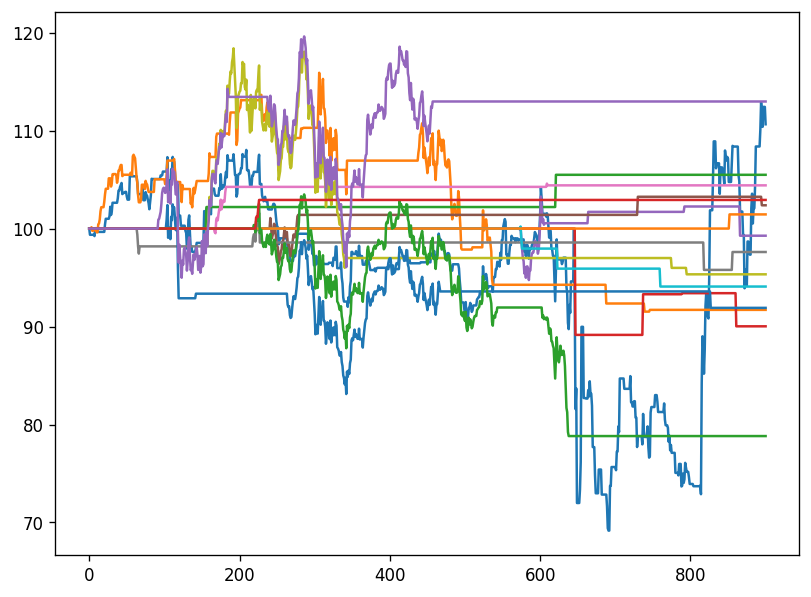

In [11]:
# plot the training results throughout each episode:
figure(figsize=(8, 6), dpi=120)
for arr in returns_:
  plt.plot(arr)
plt.show()

In [12]:
np.mean(returns_)-100

-0.23623112053275008

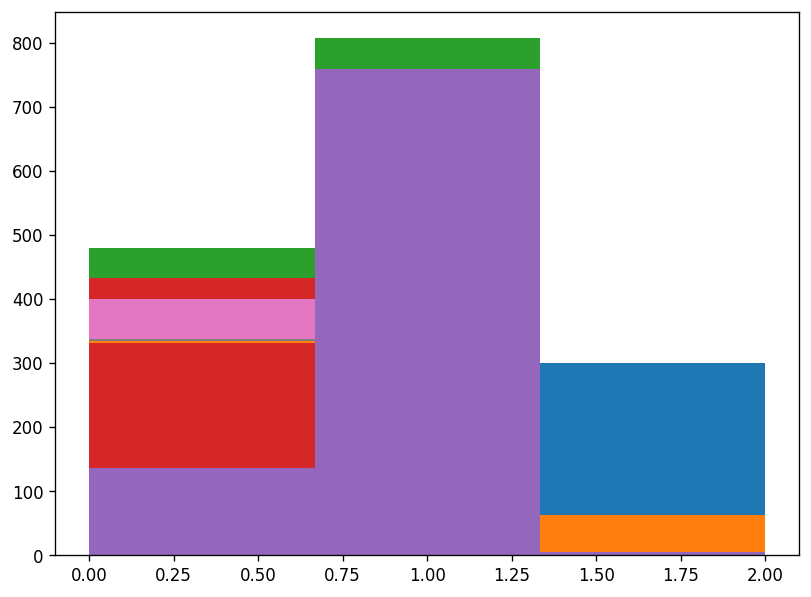

In [13]:
figure(figsize=(8, 6), dpi=120)
for arr in actions_:
  plt.hist(arr, bins=3)

In [14]:
test = getData()[-300:]

testEnv = TradingEnvironment(test, 100) # Create the Environment

scaler = get_scaler(testEnv) # get the scaler object for the replay function

state_dim = 1*2+1
gordongeckotest = TradingAgent(state_dim) # Create the Agent

# Perform training
testbalances, testactions = play_episode(gordongeckotest, testEnv, False, scaler, 1, test.shape[0])

<bound method NDFrame.head of              Date       Open       High        Low      Close  Adj Close  \
0      1962-01-02   0.000000   0.716684   0.706999   0.706999   0.053105   
1      1962-01-03   0.000000   0.716684   0.710227   0.716684   0.053832   
2      1962-01-04   0.000000   0.718298   0.703771   0.703771   0.052863   
3      1962-01-05   0.000000   0.703771   0.677944   0.684401   0.051408   
4      1962-01-08   0.000000   0.703771   0.694086   0.697314   0.052378   
...           ...        ...        ...        ...        ...        ...   
15197  2022-05-16  30.620001  31.290001  30.600000  31.020000  31.020000   
15198  2022-05-17  31.559999  31.690001  31.270000  31.480000  31.480000   
15199  2022-05-18  31.879999  32.060001  30.940001  31.110001  31.110001   
15200  2022-05-19  30.549999  31.389999  30.549999  31.030001  31.030001   
15201  2022-05-20  31.370001  31.799999  30.750000  31.280001  31.280001   

         Volume  
0         77440  
1         85184  
2  

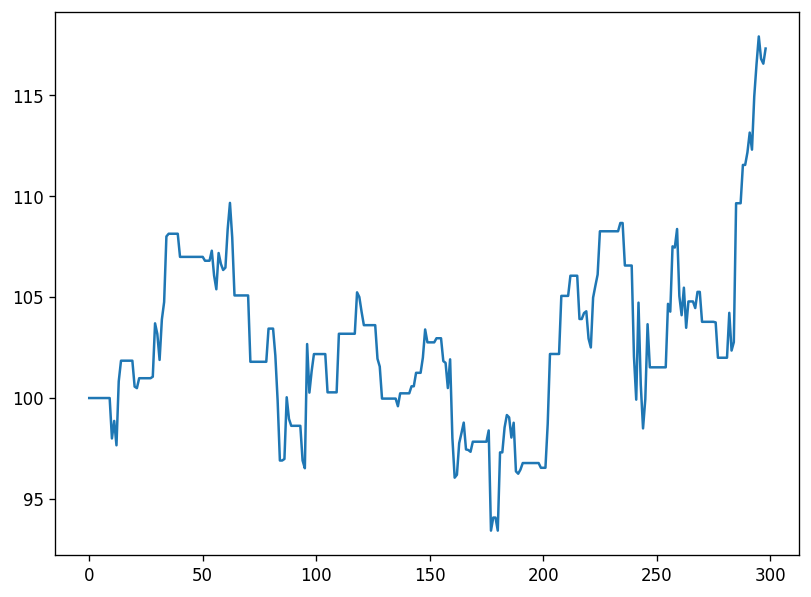

In [16]:
figure(figsize=(8, 6), dpi=120)
plt.plot(testbalances)

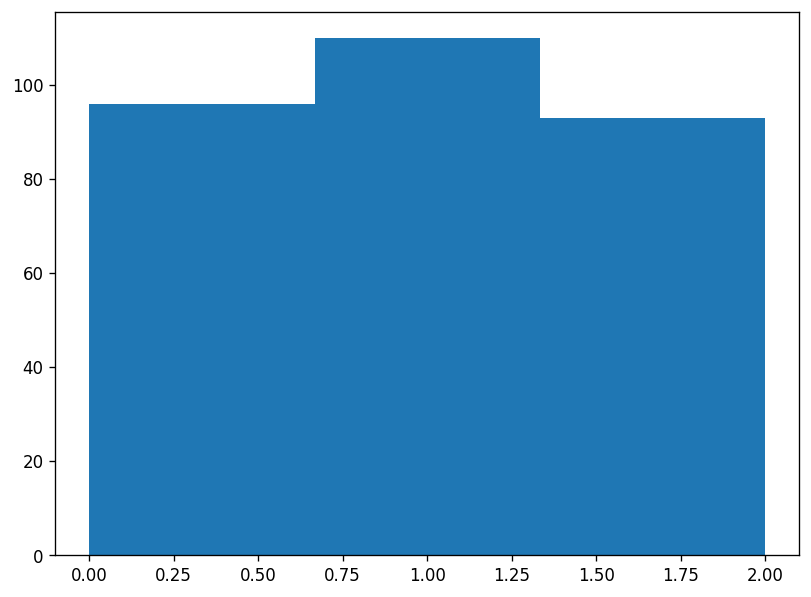

In [23]:
figure(figsize=(8, 6), dpi=120)
_ = plt.hist(testactions, bins=3)